In [3]:
import torch
import torch.nn as nn # for neural network stuff (stateful)
import torch.nn.functional as func # for neural network operations (stateless)
import numpy as np
import matplotlib.pyplot as plt



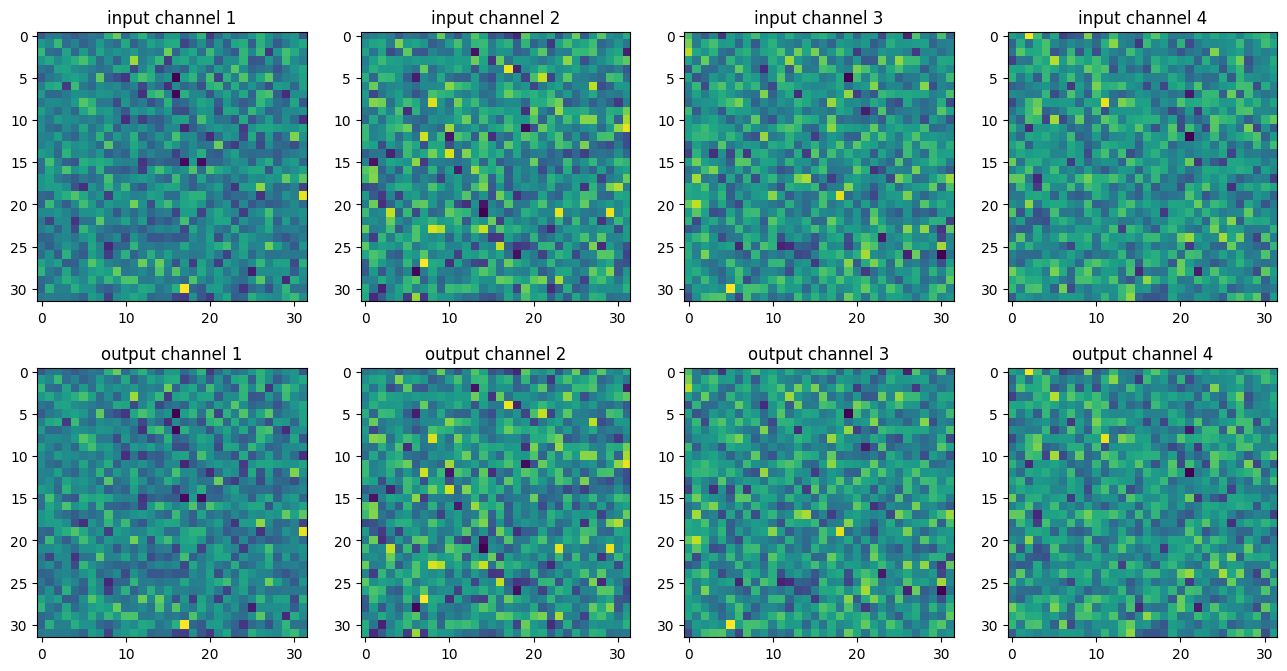

input shape: torch.Size([2, 64, 32, 32])
output shape: torch.Size([2, 128, 32, 32])
Total parameters in DCT module: 3216


In [4]:
#######
# DCT hyper parameters: reduction ratio, replication ratio, 

# repl == expansion_ratio and reduc == reduction_ratio?
class DCT(nn.Module):
    def __init__(self, input_channels, reduc=4, repl=2):
        super(DCT, self).__init__()
        self.reduc = reduc
        self.repl = repl
        self.output_channels = input_channels * repl

        self.GAP = torch.nn.AdaptiveAvgPool2d(1) # global average pooling
        hidden_channels = input_channels // reduc # get number of hidden channels, which is determined by reduction ratio hyperparam
        self.fc1 = torch.nn.Conv2d(input_channels, hidden_channels, 1) # fully connected layer to compress
        self.fc2 = torch.nn.Conv2d(hidden_channels, self.output_channels, 1) # fully connected layer to mix channels
        self.sigmoid = nn.Sigmoid() # activation function

    def forward(self, x):
        b, c, h, w = x.size() # get batch size, channels, height and width of input tensor
        
        replicated = x.repeat(1, self.repl, 1, 1) # dupliates channels of input tensor
        
        pool = self.GAP(x) # do the global average pooling
        
        first_FC = self.fc1(pool) 
        second_FC = self.fc2(first_FC)
        activation = self.sigmoid(second_FC)
        recalibrated = activation.view(b, self.output_channels, 1, 1) # reclibrated is 2d, view makes it into a tensor
        
        output = replicated + recalibrated
        
        return output

if __name__ == "__main__":
    # visualization plot
    fig, axarr = plt.subplots(2, 4, figsize=(16, 8))
    
    # test input
    test_input = torch.randn(2, 64, 32, 32)  

    # plot input
    for i in range(4):
        axarr[0, i].imshow(test_input[0, i].numpy(), cmap='viridis')
        axarr[0, i].set_title(f'input channel {i+1}')
    
    dct = DCT(input_channels=64, repl=2, reduc=4)
    output = dct(test_input)

    # plot output
    for i in range(4):
        axarr[1, i].imshow(output[0, i].detach().numpy(), cmap='viridis')
        axarr[1, i].set_title(f'output channel {i+1}')
    
    plt.show()
    print(f"input shape: {test_input.shape}")
    print(f"output shape: {output.shape}")
    
    # count parameters
    total = 0
    for parameter in dct.parameters():
        total = total + parameter.numel()
    print(f"Total parameters in DCT module: {total}")

In [20]:
####
# DCT bottleneck parameters: input_channels, output_channels, stride, expansion ratio, reduction ratio

class DCT_bottleneck(nn.Module):
    def __init__(self, input_channels, output_channels, s=1, repl=2, reduc=4):
        super(DCT_bottleneck, self).__init__()
        self.s = s
        self.input_channels = input_channels
        self.output_channels = output_channels
        self.repl = repl
        self.reduc = reduc
        self.check_connec_resid = (s==1 and input_channels == output_channels)

        # calculating intermed. channels
        dct_input_channels = output_channels // repl
        midpt_channels = dct_input_channels // 2


        # Layer 1 3*3 convolution (dwconv operator - depthwise convolution)
        self.dw_conv = nn.Conv2d(in_channels = input_channels, out_channels = input_channels, 
                                kernel_size=3, stride = s, padding=1, groups=input_channels, bias=False)
        self.dw_batch_norm1 = nn.BatchNorm2d(num_features = input_channels)
        self.dw_relu_activ1 = nn.ReLU6(inplace=True)

        # Layer 2 1*1 convolution (conv2d operator - pointwise convolution)
        self.conv1 = nn.Conv2d(in_channels = input_channels, out_channels = midpt_channels,
                                  kernel_size=1, stride=1, padding=0, bias=False)
        self.batch_norm2 = nn.BatchNorm2d(midpt_channels)
        self.relu_activ2 = nn.ReLU6(inplace=True)

        # Layer 3 1*1 convolution (pwconv operator - pointwise convolution)
        self.conv2 = nn.Conv2d(in_channels = midpt_channels, out_channels = midpt_channels,
                                  kernel_size=1, stride=1, padding=0, bias=False)
        self.batch_norm3 = nn.BatchNorm2d(num_features = midpt_channels)


        # Layer 4 DCT implementation
        self.dct = DCT(input_channels = midpt_channels*2, 
                       reduc=reduc, repl=repl)

        if self.check_connec_resid:
            self.resid_connec_branch = nn.Identity()
        else:
            self.resid_connec_branch = nn.Sequential(
                nn.Conv2d(in_channels = input_channels, out_channels = output_channels,
                          kernel_size=1, stride=s, bias=False),
                nn.BatchNorm2d(num_features = output_channels)
            )

    def forward(self, x):

        #residual connection response
        identity = self.resid_connec_branch(x)

        # layer 1 depth-wise 3*3 convolution
        output_l1 = self.dw_conv(x)
        output_l1 = self.dw_batch_norm1(output_l1)
        output_l1 = self.dw_relu_activ1(output_l1)

        # Layer 2 first 1*1 pw conv.
        output_l2 = self.conv1(output_l1)
        output_l2 = self.batch_norm2(output_l2)
        output_l2 = self.relu_activ2(output_l2)

        # Layer 3 second 1*1 pw conv.
        output_l3 = self.conv2(output_l2)
        output_l3 = self.batch_norm3(output_l3)

        # concatenation step (concat first and second 1*1 pw conv.)
        output_pw_concat = torch.cat([output_l2, output_l3], dim=1)

        # DCT step
        output_dct = self.dct(output_pw_concat)

        # Resid connec
        output_final = output_dct + identity

        return output_final



if __name__ == "__main__":
    test_input = torch.randn(2, 64, 32, 32)
    
    # Same input/output channels with stride=1 (with residual)
    bottleneck1 = DCT_bottleneck(input_channels=64, output_channels=64, s=1)
    output1 = bottleneck1(test_input)
    print("Test1: Bottleneck with residual - input=output, stride=1")
    print("Input:", test_input.shape)
    print("Output:", output1.shape)
    
    # Different channels with stride=2 (no residual)
    bottleneck2 = DCT_bottleneck(input_channels=64, output_channels=128, s=2)
    output2 = bottleneck2(test_input)
    print("Test2: Bottleneck without residual - input!=output, stride=2")
    print("Input:", test_input.shape)
    print("Output:", output2.shape)
    

Test1: Bottleneck with residual - input=output, stride=1
Input: torch.Size([2, 64, 32, 32])
Output: torch.Size([2, 64, 32, 32])
Test2: Bottleneck without residual - input!=output, stride=2
Input: torch.Size([2, 64, 32, 32])
Output: torch.Size([2, 128, 16, 16])
